In [4]:
import pandas as pd
import numpy as np
import cv2
import pytesseract
custom_config = r' — oem 3 — psm 6'
from matplotlib import pyplot as plt

# import image

In [5]:
from pdf2image import convert_from_path
pages = convert_from_path(r"C:\Users\siva\Desktop\metagenic\B655_V1098_SC0002790.PDF")

#Saving pages in jpeg forma\
for i, img in enumerate(pages):
    fname = 'img'+str(i)+'.png'
    img.save(fname, "PNG") 

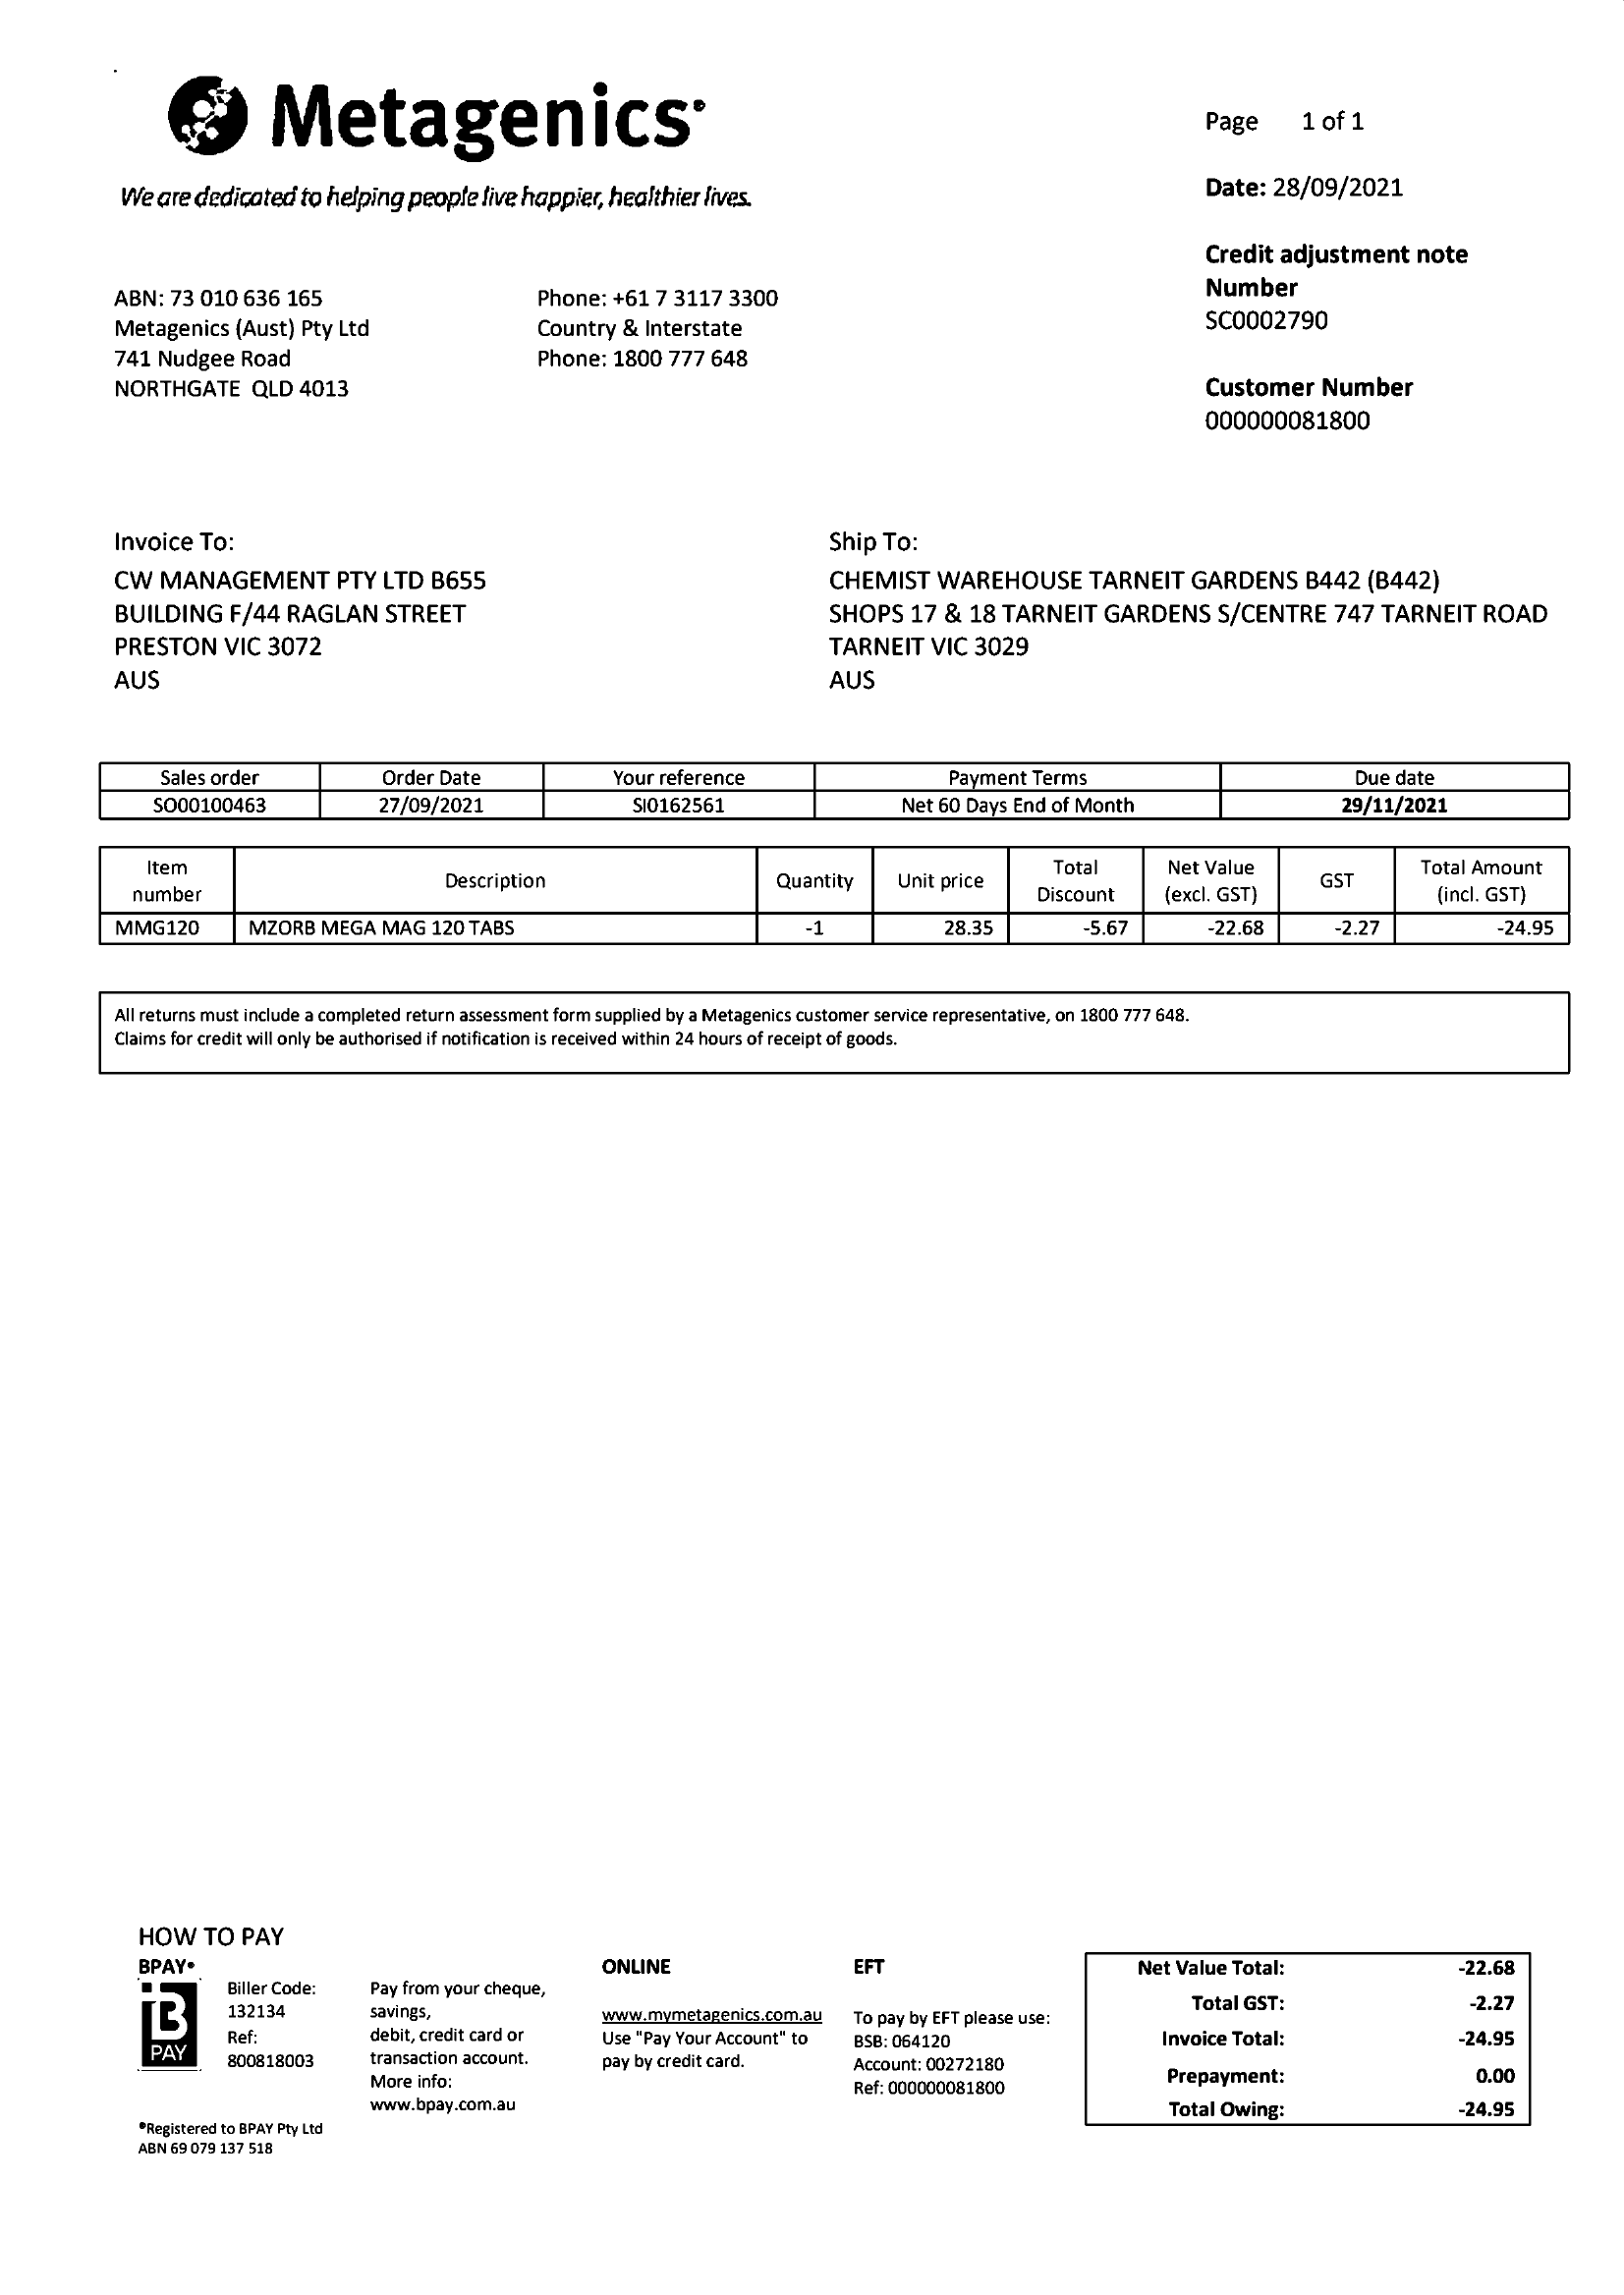

In [6]:
img

In [13]:
# load raw image
#img = cv2.imread(r"C:\Users\siva\Documents\PYTHON\cropB655.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# display raw image
plt.figure(figsize=(10,20))
plt.imshow(img)
plt.show()

error: OpenCV(4.4.0) c:\users\appveyor\appdata\local\temp\1\pip-req-build-qjdp5db9\opencv\modules\imgproc\src\color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function '__cdecl cv::impl::`anonymous-namespace'::CvtHelper<struct cv::impl::`anonymous namespace'::Set<3,4,-1>,struct cv::impl::A0x31878511::Set<1,-1,-1>,struct cv::impl::A0x31878511::Set<0,2,5>,2>::CvtHelper(const class cv::_InputArray &,const class cv::_OutputArray &,int)'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [8]:
def crop_images(pages,co_ordinates):

    """
    crop_images: (function), used to crop images using model co-ordinates for tabular region.
    -----------

    return : (list) of cropped images

    """

    img=np.array(pages)
    co_ord=list(map(int,co_ordinates))
    #cropped = img[co_ord[1]*2:int(co_ord[3]*2.2), co_ord[0]:int(co_ord[2]*2.2), :]
    if cord_type==1:
        hh,ww,_=img.shape
        cropped = img[co_ord[1]*2:(co_ord[3]*2)+(co_ord[3]//8), co_ord[0]+(co_ord[0]//2):ww-co_ord[0], :]
    else:
        if(dpi==600):
            cropped = img[(co_ord[1])*2:(co_ord[3])*2, (co_ord[0])*2:(co_ord[2])*2, :]
        if(dpi==150):
            cropped = img[co_ord[1]//2:(co_ord[3]-500)//2, co_ord[0]//2:co_ord[2]//2, :]
        else:
            cropped = img[co_ord[1]:(co_ord[3]), co_ord[0]:co_ord[2], :]
    plt.imshow(cropped)
    plt.show()
    return cropped

In [9]:
kernal = (5,5)
dpi = 600
write=True
resize=False
cord_type=0

# remove lines

In [10]:
def remove_header(c_im):

    """
    remove_header: (function), used to remove black and color header.
    -------------
    input : Original 3D image
    return : grayscale 2D image.

    """

    hsv=cv2.cvtColor(c_im,cv2.COLOR_BGR2HSV)
    # Define lower and uppper limits of what we call "brown"
    brown_lo=np.array([0,0,0])
    brown_hi=np.array([100,100,100])
    # Mask image to only select browns
    mask=cv2.inRange(hsv,brown_lo,brown_hi)
    # Change image to red where we found brown
    c_im[mask>0]=(0,0,100)
    # Make HSV and extract S, i.e. Saturation
    hsv = cv2.cvtColor(c_im, cv2.COLOR_BGR2HSV)
    s=hsv[:,:,1]
    # Save saturation just for debug
    #cv2.imwrite('saturation.png',s)
    # Make greyscale version and inverted, thresholded greyscale version
    gr = cv2.cvtColor(c_im,cv2.COLOR_BGR2GRAY)
    _,grinv = cv2.threshold(gr,155,255,cv2.THRESH_BINARY_INV)
    # Find row numbers of rows with colour in them
    meanSatByRow=np.mean(s,axis=1)
    rows = np.where(meanSatByRow>100)
    # Replace selected rows with those from the inverted, thresholded image
    gr[rows]=grinv[rows]
    return gr

In [11]:
img1=remove_header(img)
plt.imshow(img1)
plt.figure(figsize=(10,20))
plt.show()

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [6]:
def remove_lines_v2(g_image):

    """
    remove_lines_v2: (function), used to remove lines in a gray scaled image.
    ---------------
    `Method: 2`
    return : (`np.array`) cleaned gray images.

    """

    result = cv2.cvtColor(g_image,cv2.COLOR_GRAY2RGB)
    thresh = cv2.threshold(g_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Remove horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
    remove_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    # Remove vertical lines
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
    remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)

    cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(result, [c], -1, (255,255,255), 5)

    cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(result, [c], -1, (255,255,255), 5)
#     plt.imshow(result)
#     plt.show()
    return result

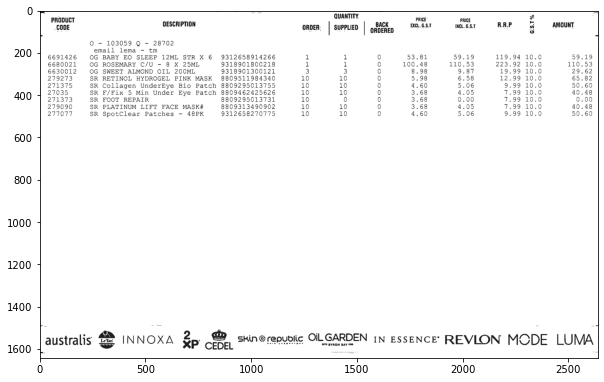

In [7]:
img2=remove_lines_v2(img1)
plt.figure(figsize=(10,20))
plt.imshow(img2)
plt.show()

In [8]:
def noise_removal(g_im):

    """
    noise_removal: (function), used to remove noise in the image.
    -------------

    return : (list) of noise filtered gray images.

    """

    #org_im = cv2.cvtColor(g_im, cv2.COLOR_GRAY2RGB)
    pre = cv2.threshold(g_im, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    # dilate the text to make it solid spot
    cpy = pre.copy()
    struct = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    cpy = cv2.dilate(~cpy, struct, anchor=(-1, -1), iterations=1)
    pre = ~cpy
    return pre

In [9]:
def draw_h_lines_v2(g_im_array):

    """
    draw_h_lines_v2: (function), used to draw horizonatal lines in a gray scaled image.
    ---------------
    `Parameters`: np.array() of gray image.
    `Method: 2`
    return : (`np.array`) lined original image.

    """
    gray = g_im_array #cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
    hh, ww = gray.shape[:2]
    # average gray image to one column
    column = cv2.resize(gray, (1,hh), interpolation = cv2.INTER_AREA)

    # threshold gray image
    thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY)[1]

    # count number of non-zero pixels in each row
    count = np.count_nonzero(thresh, axis=1)

    # threshold count at ww (width of image)
    count_thresh = count.copy()
    count_thresh[count==ww] = 255
    count_thresh[count<ww] = 0
    count_thresh = count_thresh.astype(np.uint8)

    # get contours
    contours = cv2.findContours(count_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # loop over contours and get bounding boxes and ycenter and draw horizontal line at ycenter

    l_h=list(map(cv2.boundingRect,contours))

    min_v=min(l_h)[-1]
    #l=np.array(l)
    #var=round(np.mean(l,axis=0)[-1])
    #for i in range(len(l)):
    #    if(l[i][3])>=var:
    #        l[i][3]=var

    result = g_im_array.copy()
    for cntr in l_h:
        x,y,w,h = cntr
        #if h>=min_v:
        ycenter = y+h//2
        cv2.line(result, (0,ycenter), (ww-1,ycenter), (0, 0, 0), 2)

    return l_h[::-1],result # colored image

In [10]:
def draw_v_lines_v2(g_im_array,result): #,h_result

    """
    draw_v_lines_v2: (function), used to draw vertical lines in a gray scaled image.
    ---------------
    `Parameters`: np.array() of gray image and np.array() horizontal lined image.
    `Method: 2`
    return : (`np.array`) lined original image.

    """

    gray = g_im_array #cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #img = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
    # img = im
    hh, ww = gray.shape[:2]

    # convert to grayscale 
    # gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # threshold gray image
    thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernal)
    thresh = cv2.erode(thresh, kernel, iterations=4)
    # plt.imshow(thresh)
    # count number of non-zero pixels in each column
    count = np.count_nonzero(thresh, axis=0)

    # print(count)
    # print(hh,ww)
    # threshold count at hh (height of image)
    count_thresh = count.copy()
    count_thresh[count==hh] = 255
    count_thresh[count<hh] = 0
    count_thresh = count_thresh.astype(np.uint8)

    # get contours
    contours = cv2.findContours(count_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    contours=list(contours)
    contours.insert(0,np.array([[[0,ww-3]],[[0,ww]]]))

    l_v=list(map(cv2.boundingRect,contours))
    # loop over contours and get bounding boxes and xcenter and draw vertical line at ycenter
    #result = h_result
    for cntr in l_v:
        y,x,h,w = cntr
        xcenter = x+w//2
        cv2.line(result, (xcenter,0), (xcenter, hh-1), (0, 0, 0), 2)

    return l_v[::-1],cv2.cvtColor(result,cv2.COLOR_BGR2RGB)

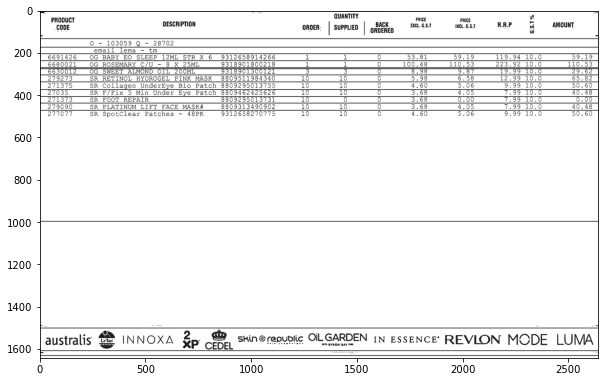

In [11]:
cols,h_line_dr=draw_h_lines_v2(img2)
plt.figure(figsize=(10,20))
plt.imshow(h_line_dr)
plt.show()

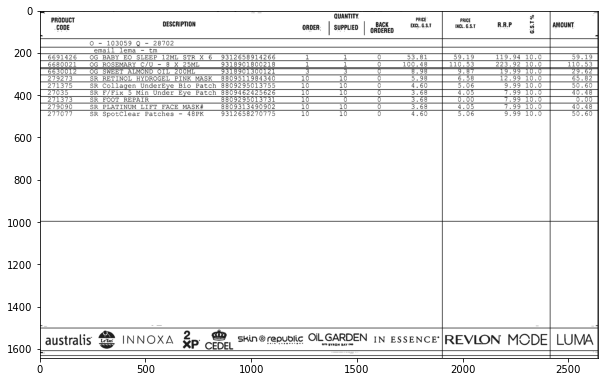

In [12]:
# import kernel
rows,result=draw_v_lines_v2(img2,h_line_dr)
plt.figure(figsize=(10,20))
plt.imshow(result)
plt.show()

In [14]:
# Load image, grayscale, Gaussian blur, Otsu's threshold
result = cv2.imread(result)
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Create rectangular structuring element and dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,10))
dilate = cv2.dilate(thresh, kernel, iterations=1)

# Find contours and draw rectangle
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0,245,12), 1)
plt.figure(figsize=(15,30))
plt.imshow(result)
plt.show()

SystemError: <built-in function imread> returned NULL without setting an error

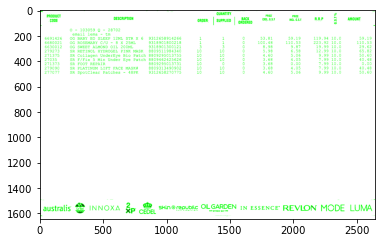

<Figure size 720x360 with 0 Axes>

In [26]:
#image = cv2.imread(img2)
result = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
ret, binary = cv2.threshold(gray, 127,255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

image = cv2.drawContours(img2, contours, -1, (0,255,0), 1)
plt.imshow(img2)
plt.figure(figsize=(10,5))
plt.show()
#plt.savefig('select.png')

In [22]:
# Adding custom options
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(result, config=custom_config)
frame=pytesseract.image_to_string(result, config=custom_config)
print(frame)

= a . a - “ ~ — Se nen 7 _
QUANTITY, se
PRODUCT , PRICE PRICE .
CODE DESCRIPTION onper; | suPPLIED | gaugaen O54 wacst RRP AMOUNT
O - 103059 Q - 28702
email lema - tm
6691426 OG BABY EO SLEEP 12ML STR X 6 9312658914266 1 1 0 53.81 59.19 119.94 10.0 59.19
6680021 OG ROSEMARY C/U - 8 X 25ML 9318901800218 1 1 0 100.48 110.53 223.92 10.0 110.53
6630012 OG SWEET ALMOND OIL 200ML 9318901300121 3 3 0 8.98 9.87 19.99 10.0 29.62
279273 SR RETINOL HYDROGEL PINK MASK 8809511984340 10 10 0 5.98 6.58 12.99 10.0 65.82
271375 SR Collagen UnderEye Bio Patch 8809295013755 10 10 0 4.60 5.06 9.99 10.0 50.60
27035 SR F/Fix 5 Min Under Eye Patch 8809462425626 10 10 0 3.68 4.05 7.99 10.0 40.48
271373 SR FOOT REPAIR 8809295013731 10 0 0 3.68 0.00 7.99 10.0 0.00
279090 SR PLATINUM LIFT FACE MASK# 8809313490902 10 10 0 3.68 4.05 7.99 10.0 40.48
277077 SR SpotClear Patches - 48PK 9312658270775 10 10 0 4.60 5.06 9.99 10.0 50.60
° an im 2c: i j 3 °
australis 2 INNOXA Zp ee. skin#reeuplic OILGARDEN IN ESSENCE’ REV

# image threshold

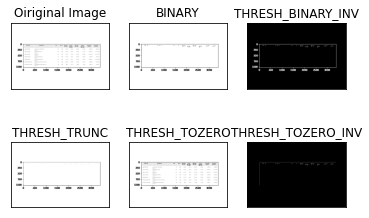

In [26]:
# apply image thresholding
gray_image = cv2.imread(r'C:\Users\siva\Documents\coca\images\result.png',0)

ret,thresh_binary = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY)
ret,thresh_binary_inv = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY_INV)
ret,thresh_trunc = cv2.threshold(gray_image,127,255,cv2.THRESH_TRUNC)
ret,thresh_tozero = cv2.threshold(gray_image,127,255,cv2.THRESH_TOZERO)
ret,thresh_tozero_inv = cv2.threshold(gray_image,127,255,cv2.THRESH_TOZERO_INV)
#DISPLAYING THE DIFFERENT THRESHOLDING STYLES
names = ['Oiriginal Image','BINARY','THRESH_BINARY_INV','THRESH_TRUNC','THRESH_TOZERO','THRESH_TOZERO_INV']
images = gray_image,thresh_binary,thresh_binary_inv,thresh_trunc,thresh_tozero,thresh_tozero_inv

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(names[i])
    plt.xticks([]),plt.yticks([])
    
plt.show()

# image counters

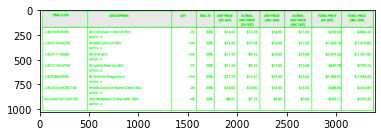

<Figure size 3600x3600 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [27]:
import cv2
import matplotlib.pyplot as plt

#image = cv2.imread(r'C:\Users\siva\Documents\coca\images\crop returnauthority04203794fullreturn-1.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
ret, binary = cv2.threshold(gray, 127,255, cv2.THRESH_BINARY_INV)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

image = cv2.drawContours(img2, contours, -1, (0,255,0), 2)
plt.imshow(image)
plt.figure(figsize=(50,50))
plt.show()
plt.savefig('select.png')

In [15]:
%time df=data_frame(exts)

NameError: name 'data_frame' is not defined

# image to string

In [57]:
import cv2 
import pytesseract

img = cv2.imread(r'C:\Users\siva\Documents\coca\images\crop returnauthority04203794fullreturn-1.png')

# Adding custom options
custom_config = r'--oem 3 --psm 6'
pytesseract.image_to_string(img, config=custom_config)
frame=pytesseract.image_to_string(img, config=custom_config)
print(frame)

ITEM CODE DESCRIPTION QTY DISC % | UNIT PRICE ACTUAL UNIT PRICE ACTUAL TOTAL PRICE TOTAL PRICE
(EX GST) UNIT PRICE (INC GST) UNIT PRICE (EX GST) (INC GST)
(EX GST) (INC GST)

J-BLD109-FO90 BI Cod Liver + Fish Oil 90's -72 30% $14.55 $10.18 $16.00 $11.20 -$733.09 $-806.40
BATCH: X

J-BLD110-MC90 BI Milk Calcium 90's -144 30% $14.55 $10.18 $16.00 $11.20 -$1,466.18 $-1,612.80
BATCH: X

J-BLD111-DA60 BI DHA 60's -144 20% $11.45 $9.16 $12.60 $10.08 -$1,319.56 $-1,451.52
BATCH: X

J-BLD113-LUY60 BI Lysine Step Up 60's -72 20% $11.45 $9.16 $12.60 $10.08 -$659.78 $-725.76
BATCH: X

J-BLD206-DP60 BI DHA for Pregnancy -144 30% $17.73 $12.41 $19.50 $13.65 -$1,786.91 $-1,965.60
BATCH: X

J-BLD216-MCBC150 BI Milk Calcium Bone Care 150s -24 20% $15.00 $12.00 $16.50 $13.20 -$288.00 $-316.80
BATCH: X

MJ-MAX107-CMT150 MG Blueberry Chew Milk 150's -48 20% $8.91 $7.13 $9.80 $7.84 -$342.11 $-376.32
BATCH: X



In [69]:
import cv2
import numpy as np
import pytesseract
from PIL import Image
src_path = r'C:\Users\siva\Documents\coca\images\crop returnauthority04203794fullreturn-1.png'
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


print (src_path)


# Read image with opencv
img = cv2.imread(src_path)

# Convert to gray
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply dilation and erosion to remove some noise
kernel = np.ones((1, 1), np.uint8)
img = cv2.dilate(img, kernel, iterations=1)
img = cv2.erode(img, kernel, iterations=1)

# Write image after removed noise
cv2.imwrite(src_path + "removed_noise.png", img)

#  Apply threshold to get image with only black and white
#img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)

# Write the image after apply opencv to do some ...
cv2.imwrite(src_path + "thres.png", img)

# Recognize text with tesseract for python
rock = pytesseract.image_to_string(Image.open(src_path + "thres.png"))


# Remove template file
#os.remove(temp)


#print ('--- Start recognize text from image ---')
print (rock)

C:\Users\siva\Documents\coca\images\crop returnauthority04203794fullreturn-1.png
ITEM CODE

D109-FO90

D110-MC90

D111-DA60

LD113-LUY60

D206-DP60

LD216-MCBC150

MJ-MAX107-CMT150

DESCRIPTION

BI Cod Liver + Fish Oil 90's
BATCH: X

BI Milk Calcium 90's
BATCH: X

BI DHA 60's
BATCH: X

BI Lysine Step Up 60's
BATCH: X

BI DHA for Pregnancy

BATCH: X

BI Milk Calcium Bone Care 150s
BATCH: X

MG Blueberry Chew Milk 150's
BATCH: X

UNIT PRICE
(EX GST)

ACTUAL
UNIT PRICE
(EX GST)

UNIT PRICE
(INC GST)

ACTUAL TOTAL PRICE TOTAL PRICE
UNIT PRICE (EX GST) (INC GST)
(INC GST)

$-806.40

$-1,612.80

$-1,451.52

$-725.76

$-1,965.60

$-316.80

$-376.32




In [16]:
%time df=data_frame(exts)

NameError: name 'data_frame' is not defined

In [11]:
from PIL import Image
import pytesseract

df = pytesseract.image_to_data(Image.open(r'C:\Users\siva\Documents\coca\images\crop returnauthority04203794fullreturn-1.png'),lang='eng',output_type='data.frame')
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,3392,1029,-1.000000,NaN
1,2,1,1,0,0,0,129,40,161,24,-1.000000,NaN
2,3,1,1,1,0,0,129,40,161,24,-1.000000,NaN
3,4,1,1,1,1,0,129,40,161,24,-1.000000,NaN
4,5,1,1,1,1,1,129,40,63,23,96.702057,ITEM
...,...,...,...,...,...,...,...,...,...,...,...,...
196,5,1,28,1,1,1,3215,883,133,33,90.327934,$-376.32
197,2,1,29,0,0,0,21,0,3363,1029,-1.000000,NaN
198,3,1,29,1,0,0,21,0,3363,1029,-1.000000,NaN
199,4,1,29,1,1,0,21,0,3363,1029,-1.000000,NaN


In [29]:
df = pytesseract.image_to_data(Image.open(r'C:\Users\siva\Documents\coca\images\crop returnauthority04203794fullreturn-1.png'),lang='eng')
print(df)

level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	3392	1029	-1	
2	1	1	0	0	0	129	40	161	24	-1	
3	1	1	1	0	0	129	40	161	24	-1	
4	1	1	1	1	0	129	40	161	24	-1	
5	1	1	1	1	1	129	40	63	23	96.702057	ITEM
5	1	1	1	1	2	203	40	87	24	96.095337	CODE
2	1	2	0	0	0	114	209	175	26	-1	
3	1	2	1	0	0	114	209	175	26	-1	
4	1	2	1	1	0	114	209	175	26	-1	
5	1	2	1	1	1	114	209	175	26	91.907036	D109-FO90
2	1	3	0	0	0	114	321	188	26	-1	
3	1	3	1	0	0	114	321	188	26	-1	
4	1	3	1	1	0	114	321	188	26	-1	
5	1	3	1	1	1	114	321	188	26	91.283218	D110-MC90
2	1	4	0	0	0	114	434	180	26	-1	
3	1	4	1	0	0	114	434	180	26	-1	
4	1	4	1	1	0	114	434	180	26	-1	
5	1	4	1	1	1	114	434	180	26	78.591644	D111-DA60
2	1	5	0	0	0	100	547	202	26	-1	
3	1	5	1	0	0	100	547	202	26	-1	
4	1	5	1	1	0	100	547	202	26	-1	
5	1	5	1	1	1	100	547	202	26	92.661209	LD113-LUY60
2	1	6	0	0	0	114	659	175	26	-1	
3	1	6	1	0	0	114	659	175	26	-1	
4	1	6	1	1	0	114	659	175	26	-1	
5	1	6	1	1	1	114	659	175	26	90.166618	D206-DP60
2	1	7	0	0	0	56	

# To create a dataframe

In [35]:
with open('rock.txt', 'w') as f:
    print(rock, file=f)

In [88]:
import pandas as pd

df=pd.read_table(r'C:\Users\siva\Desktop\python\json folder\rock.txt',encoding='latin1')

print(df)

,ITEM CODE
0,D109-FO90
1,D110-MC90
2,D111-DA60
3,LD113-LUY60
4,D206-DP60
5,LD216-MCBC150
6,MJ-MAX107-CMT150
7,DESCRIPTION
8,BI Cod Liver + Fish Oil 90's
9,BATCH: X


In [94]:
import pandas as pd
df=pd.read_table('rock.txt',encoding='latin1')
df

,ITEM CODE
0,D109-FO90
1,D110-MC90
2,D111-DA60
3,LD113-LUY60
4,D206-DP60
5,LD216-MCBC150
6,MJ-MAX107-CMT150
7,DESCRIPTION
8,BI Cod Liver + Fish Oil 90's
9,BATCH: X


In [39]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ITEM CODE  39 non-null     object
dtypes: object(1)
memory usage: 440.0+ bytes
None


# To create a json

In [40]:
data = df.to_json(orient='columns')
print(data)


{"ITEM CODE":{"0":"D109-FO90","1":"D110-MC90","2":"D111-DA60","3":"LD113-LUY60","4":"D206-DP60","5":"LD216-MCBC150","6":"MJ-MAX107-CMT150","7":"DESCRIPTION","8":"BI Cod Liver + Fish Oil 90's","9":"BATCH: X","10":"BI Milk Calcium 90's","11":"BATCH: X","12":"BI DHA 60's","13":"BATCH: X","14":"BI Lysine Step Up 60's","15":"BATCH: X","16":"BI DHA for Pregnancy","17":"BATCH: X","18":"BI Milk Calcium Bone Care 150s","19":"BATCH: X","20":"MG Blueberry Chew Milk 150's","21":"BATCH: X","22":"UNIT PRICE","23":"(EX GST)","24":"ACTUAL","25":"UNIT PRICE","26":"(EX GST)","27":"UNIT PRICE","28":"(INC GST)","29":"ACTUAL TOTAL PRICE TOTAL PRICE","30":"UNIT PRICE (EX GST) (INC GST)","31":"(INC GST)","32":"$-806.40","33":"$-1,612.80","34":"$-1,451.52","35":"$-725.76","36":"$-1,965.60","37":"$-316.80","38":"$-376.32"}}


In [84]:
import json
with open('rock.json', 'w') as json_file:
    json.dump(rock, json_file)

# To extract the data with coordinates using easyocr

In [11]:
import os

In [6]:
pip install easyocr

In [12]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [42]:
# Changing the image path
IMAGE_PATH = r'C:\Users\siva\Documents\coca\images\crop returnauthority04203794fullreturn-1.png'

In [43]:
import easyocr
reader = easyocr.Reader(['en'], gpu=False)
result = reader.readtext(IMAGE_PATH)
result

Using CPU. Note: This module is much faster with a GPU.


[([[121, 34], [297, 34], [297, 71], [121, 71]],
  'ITEM CODE',
  0.9992697993883428),
 ([[696, 39], [898, 39], [898, 77], [696, 77]],
  'DESCRIPTION',
  0.8580777818025747),
 ([[1418, 40], [1480, 40], [1480, 73], [1418, 73]], 'QTY', 0.9957976664988654),
 ([[1616, 39], [1730, 39], [1730, 77], [1616, 77]],
  'DISC %',
  0.9257387704634105),
 ([[1789, 40], [1952, 40], [1952, 73], [1789, 73]],
  'UNIT PRICE',
  0.8812269037038781),
 ([[2035, 40], [2156, 40], [2156, 73], [2035, 73]],
  'ACTUAL',
  0.9999456386415766),
 ([[2263, 40], [2429, 40], [2429, 73], [2263, 73]],
  'UNIT PRICE',
  0.9998804954493966),
 ([[2552, 40], [2675, 40], [2675, 73], [2552, 73]],
  'ACTUAL',
  0.9999492400412812),
 ([[2812, 40], [3004, 40], [3004, 73], [2812, 73]],
  'TOTAL PRICE',
  0.9991558006540908),
 ([[3111, 40], [3303, 40], [3303, 73], [3111, 73]],
  'TOTAL PRICE',
  0.9777891941807783),
 ([[1804, 84], [1945, 84], [1945, 127], [1804, 127]],
  '(EX GST)',
  0.9971918807533591),
 ([[2014, 85], [2177, 85], [

# To import more the image to extract the data

In [17]:
from PIL import Image
import pytesseract
import os
import pandas as pd

# Path is given for for 64 bit installer
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"

f = []
t = []
input_dir = r'C:/Users/siva/Documents/PYTHON/'

for root, dirs, filenames in os.walk(input_dir):
    for filename in filenames:
        try:
            print(filename)
            f.append(filename)
            img = Image.open(input_dir+ filename)
            text = pytesseract.image_to_string(img, lang = 'eng')
            t.append(text)
            print(text)
            print('-='*20)
        except:
            continue


dataframe = pd.DataFrame(list(zip(f, t)),columns=['file_Name','Text','DESCRIPTION'])


B733_2194981_20220226_V1983.jpg
TAX INVOICE REMITTANCE ADVICE
CW Management Pty Ltd B6o55

|
|
H CW Management Pty Ltd B6o55 2194981 |
Cr] ‘al OC fan S 44 Raglan Street No:
| INV. NO.:
|
|

PRESTON 3072 PAGE: 1 2194981
Heritage Brands (Australia Pty Ltd) PO Box 1435 30 Bando Road
ABN: 62 111 665 439 Clayton South Springvale VIC 3171 pespatcH: 7° FEB 22 pate: 70 FEB 22
® 1300 650 981, +61 3 8586 2100  +6139574 2144 © www.heritagebrands.com.au

CON NOTE: ACCT:

9CWHB7 33
NORTH HOBART B73

NOHZ0219498

ACCT: 9CWHB733 S/MAN: Cozmic - CWH Promo AREA: =. 3333p Customer Order No: OGNPDFEB22L

QUANTITY =
PRODUCT Ico 4 ae saa 3

6691551 Pink Grapefruit 25mL 9312658915515
6691552 Lemon Tea Tree 25mL 9312658915522
6691553 Peppermint Eucalypt 25mL 9312658915539
6691554 Blue Mallee 25mL 9312658915546
6691555 Australian Fennel 25mL 9312658915553
6691556 Mandarin 25mL 9312658915560
6691557 3-IN-1 Diffuser Sandy 9312658915577
6691568 Defence 25mL 9312658915683
6691570 Stress 25mL 9312658915706
6691571

Tax Invoice: 2802404 4 Ri
ax Invoice S2% BioCeutical

FIT-BioCeuticals Ltd Phone: 1300 650 455

A.B.N. 77 062 851 683 Fax: 02 9080 0941

PO Box 6454, Alexandria Email: accountsreceivable@fit.net.au
NSW Australia 2015

Ship To:

CWH BONDI JUNCTION B049
Shop 1,

Quickly and easily access herb/nutrient and drug interaction
Information using your BloCeuticals website login

1 33-1 35 Oxford Street, €) IMGATEWAT Supported by Ihigatewayy® in conjunction with The University of Sydney
BONDI JUNCTION NSW 2022

Client Order AIC No. Terms Date
97557 End of month following invoice 26/08/2020

Part No. Description Batch No. RRP Qty OrdQty Sup Qty B/O_ Qty Price + Disc% GST Total
Inc Cancelled (Fy

B.LIPO.60 BC LivProtect (60) 200198 38.00 19.5840
B.LIPOB12.50 BC Liposomal Methyl B12 32933 46.90 24.1655
B.LIPOD3.50 BC Liposomal D3 (50ml) 32918 36.00 18.5470
B.K2CAPS.60 BC K2 Capsules (60) 200425 42.20 21.7430
B.IODISP.50 BC lodine Forte Oral (50ml) 003405 25.95 13.3705
B.IODI.50 BC lodine Drops (50m

7 = L'Oréal Australia Pty Ltd Order & Delivery Enquiries: 1300 659 259
. Account Enquiries: 1300 659 259
L’ 2 EAL. 15 Imagine Way, Technical Enquiries: 1300 659 359

PARIS Dandenong South, Vic 3175 Facsimile: 03 8680 0951
PO Box 163, Hampton Park Vic 3976 Email Address :
CPD.ManualOrders@loreal.com for customer care
LABORATOIRES . CPD.Payments@loreal.com for Payment
GA RNIER MAYBEL LI! NE (ABN 40 004 191 673) (ACN 004 191 673) aupharmacyclaims@loreal.com for claim management

CW MANAGEMENT P/L B655 0006138990
44-54 RAGLAN ST AMOUNT PAYABLE

PRESTON, VIC 3072 INC. G.S.T.

DUE DATE :

ouma-—-oOo<2Z=—

Dear Customers,
We would like to inform you of our stocktake closure dates:
* Thursday 30th & Friday 1st of October 2021: Melbourne Warehouse Closed for stocktake

Order Date -Tues 28th of Sept 2021 - before 2pm
Despatch date from L’Oréal National Distribution Centre (Melbourne)- Wed 29th of Sept 2021

Order Date -Tues 28th of Sept 2021 - after 2pm
Despatch date from L’Oréal National Distri

C)MBRELLO TAX INVOICE

THE EXEeTS IN FABHIOM ACCESSORIES 60644
Unit 1 176 - 180 Euston Road Alexandria NSW 2015
Ph: 02 9564 8336 e-mail: accounts@vimwood.com.au CUST REF: C6719
ABN: 68 003 910 281
Bill To ShipTo
CW Management Pty Ltd B655 Chemist Warehouse Midland Military Markets B718
44 Raglan St Tenancy 12A 7 Clayton Street
PRESTON VIC 3072 Midland
AUSTRALIA WA 6056

PAGE

SALESPERSON INTERNAL REF NO. PAYMENT DUE DATE TERMS DATE
Karen Moffett PP2810 30/06/21 30 Days from oe 06/05/21
Statement

o_o fo [a [> EE
9332705397989 |}CAP CLAW MILKY TORT BRN 775478 AUD 2.720 rm Powe 2.584 ie)
9332705409743 |CAP LDS OS S/CHIE LEO 440657 9.990 oa 34.18
9332705409583 |CAP LDS TIE PL BLUSH 2P 584355 7.990 Jauo4.360| 5.00 | 4142 | 1243 13.67
9332705409668 |CAP LDS PRINTED H/WRAP 883746 7.990 mwaapaw law | ue pia | mer
9332705409576 |CAP LDS BEAD H/TIES 5PK 854777 5.990 vo fwosinf ow bow | ox fon | a
9332705355279 |LDS VEL SCRUNCHIE 2 BLK 748975 1.09 11.95
CAP SCH S/CHIE NAVY 3PK 158775 1.55 17.09


ValueError: 3 columns passed, passed data had 2 columns

In [18]:
dataframe

NameError: name 'dataframe' is not defined

In [102]:
data = df.to_json(orient='columns')
print(dataframe)

                                            file_Name  \
0                                        100326-1.png   
1                                        100527-1.png   
2                                        100625-1.png   
3     637558871719182208_rocktape-invoice-30147-1.png   
4                           B655_V1127_92058007-1.png   
5                           B655_V1127_92058008-1.png   
6                           B655_V1127_92058016-1.png   
7                        B655_V1983_2059428.PDF-1.png   
8       B655_V1983_2059428.PDF-1.pngremoved_noise.png   
9               B655_V1983_2059428.PDF-1.pngthres.png   
10                       B655_V2694_2816035.PDF-1.png   
11       crop returnauthority04203794fullreturn-1.png   
12  crop637558871719182208_rocktape-invoice-30147-...   
13  crop637558871719182208_rocktape-invoice-30147-...   
14  crop637558871719182208_rocktape-invoice-30147-...   
15          cropB655_V1983_2059428.PDF-1.pngthres.png   
16  cropB655_V1983_2059428.PDF-